

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Subsurface Machine Learning Graduate Student Project
_____________________

## Bias-variance trade-off for decision tree regressor

#### Jiaqi Du
#### The Hildebrand Department of Petroleum and Geosystems Engineering, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________
Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/leiliu96)



_____________________

### Executive Summary

The goal of this workflow is to demonstrate how the error components and performance vary with model complexity increasing across various decision tree-based regressors. By delivering bias-variance trade-off and visulization the results, I found the performance quality of random forese is better than decision tree and boosting is better than baggging. Another point I pay attention to is better tree-based regressors usually has better control on variance. Based on this analysis, it's a good idea to use gradient boosting regressor, but should be careful about the choice of learning rate.

### Import Packages

To access the expected loss, bias and variance, we need to install package named mlxtend
```python
pip install mlxtend                                        
```

In [1]:
from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import DecisionTreeRegressor              # decision tree method
from sklearn.ensemble import BaggingRegressor               # bagging tree method
from sklearn.ensemble import RandomForestRegressor          # random forest method
from sklearn.ensemble import GradientBoostingRegressor      # tree-based gradient boosting

import pandas as pd                                         # DataFrames and plotting
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting

from mlxtend.evaluate import bias_variance_decomp           # get total error, bias square and variance of model

import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
#define function to calculate total error, bias square and variance of model
def calculate_bias_variance(model, X_train, y_train, X_test, y_test, random_seed):  
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='mse', random_seed=random_seed)
    return avg_expected_loss, avg_bias, avg_var


#define function to plot bias-variance off for step1
def plot_data(ax, depths, tree_data, bag_data, forest_data, title, xlabel, ylabel):
    ax.plot(depths, tree_data, label='Tree', marker='o')
    ax.plot(depths, bag_data, label='Bagging', marker='o')
    ax.plot(depths, forest_data, label='RandomForest', marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

### Load Data

The following workflow applies the .csv file 'unconv_MV.csv', a dataset from Dr. Pyrcz's GitHub respository. The dataset is publically available [here](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv)  

We will work with the following features:

* **Porosity** - fraction of rock void in units of percentage
* **Brittle** - tendency of rock to break without being distorted when exposed to stress
* **Production** - volume of hydrocarbons extracted in units of $kg/m^2s*10^3$

In [3]:
my_data = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv") # load the data from Dr. Pyrcz's GitHub respository

my_data = my_data.iloc[:300,1:8]                            # copy all rows and columns 1 through 8, note 0 column (well index)is removed

### Workflow of Bias-variance trade off for decision tree

A short/concise summary of the workflow is provided below:

1. Clean the data & treat the data

2. Main Step I: bias-variance trade-off of decisiontree, bagging and random forest over tree depth

3. Main Step II: bias-variance trade-off of bagging and boosting

4. Conclusions

### Clean the data & treat the data

There are some negative values for brittleness. Let's clean the data. In addition, it's optional to add some random noises to the production data, just make sure the 'add_noise = 1'. Without noise, the performance of each models are excellent, so I suggest add noise.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).


In [4]:
num = my_data._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                            # truncate negative values to 0.0

my_data_subset = my_data.iloc[:250,[0,3,6]]                 # extract just por, brittle and prod with 300 training samples
my_data_test_subset = my_data.iloc[250:,[0,3,6]]            # extract just por, brittle and prod with 700 testing samples

predictors = my_data_subset[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
response = my_data_subset[['Production']].copy()            # make a new DataFrame with responses features for training
predictors_test = my_data_test_subset[['Por','Brittle']].copy() # make a new DataFrame with predictor features for testing
response_test = my_data_test_subset[['Production']].copy()  # make a new DataFrame with responses for testing


#optional: add noise to overfit

add_noise = 1

if add_noise == 1:
    std_error = 500
    my_data['Production'] = my_data['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(my_data)) # add noise

### Main Step I: bias-variance trade-off of decisiontree, bagging and randomforest over tree depth

This step conducts a performance evaluation of Decision Tree, Bagging, and Random Forest regressors by calculating and plotting their expected loss, bias, and variance across different tree depths. 

I use a nested loop to iteratlly get bias-variance trade off over a set range of depths and specified tree counts, aggregating the results for visualization. The purpose of adding an external circulation about num_trees is to better evaluate the effect of tree_depth.

Please know, the bigger the value of num_trees is, the more time we need to build a model. If you prefer to have a quick view, decrease the number of num_trees and max_depth.

Complete of 20:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  
Number of trees: 1


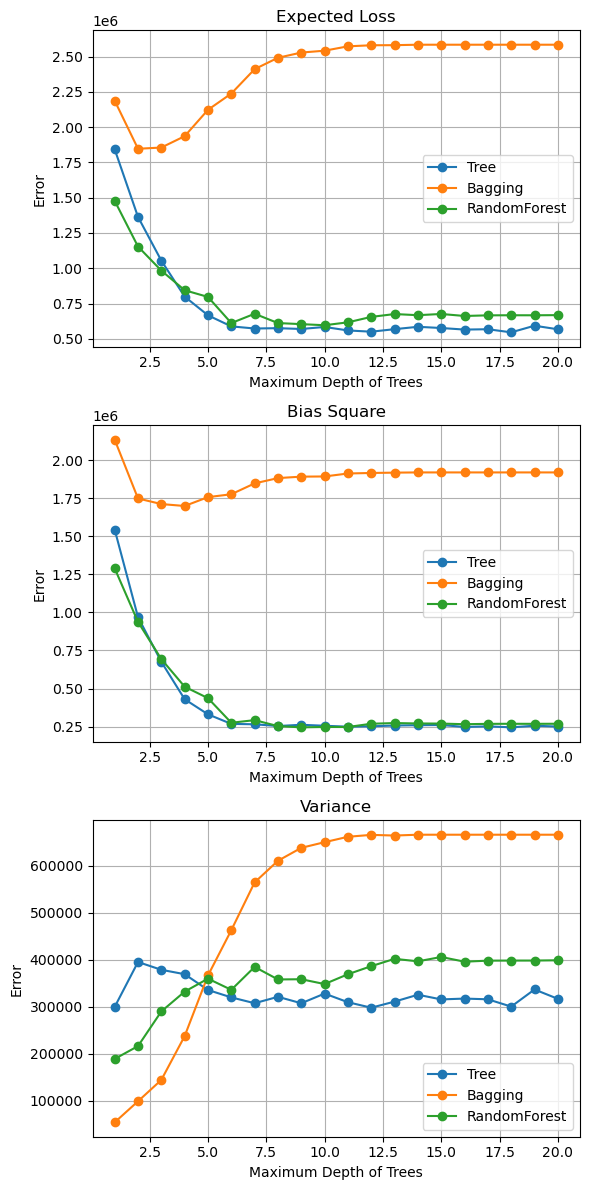

Complete of 20:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  
Number of trees: 5


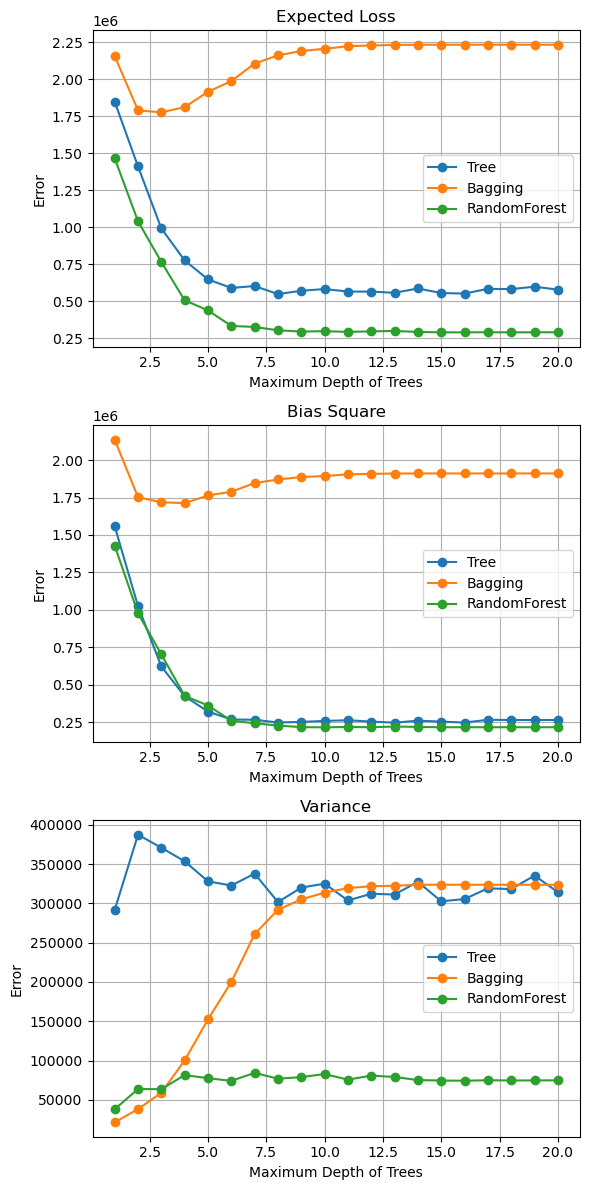

Complete of 20:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  
Number of trees: 10


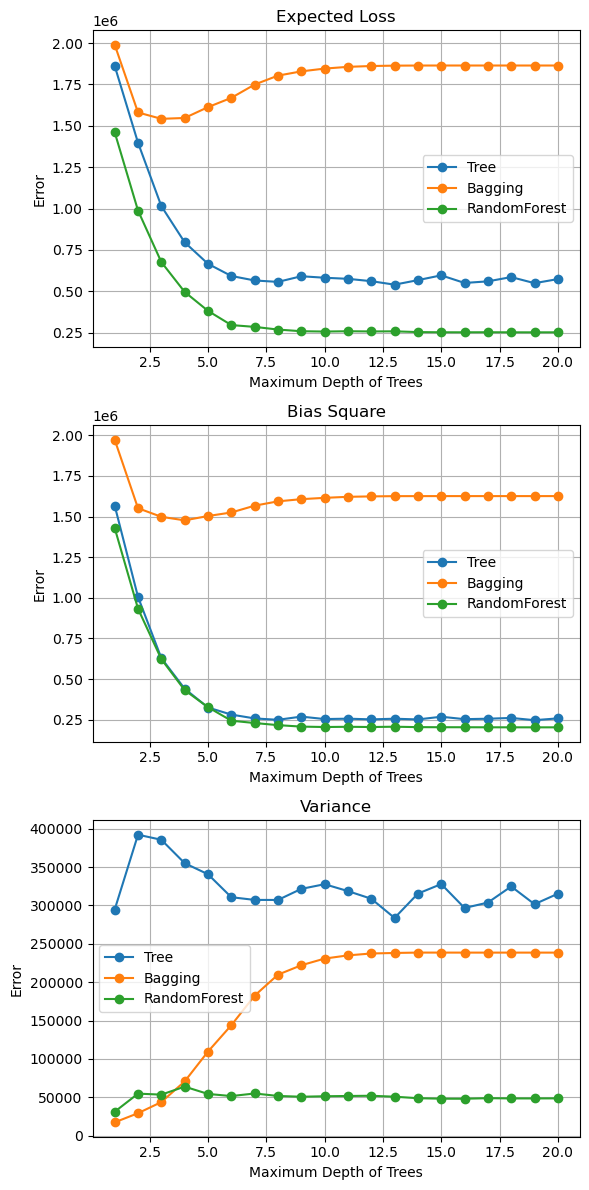

Complete of 20:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  
Number of trees: 20


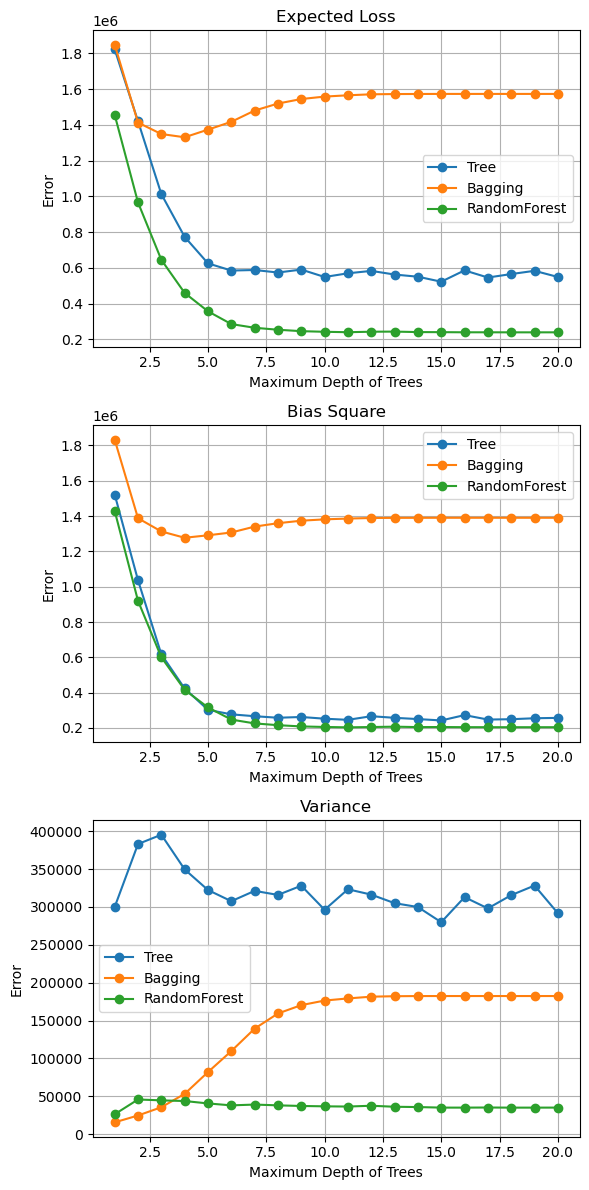

In [5]:
seed = 73031                                               # set the random forest hyperparameters
max_depths = np.linspace(1,20,20)                          # set the tree maximum tree depths to consider
num_trees = [1, 5, 10, 20]                                     # set the random forest hyperparameters
max_nodes= 20

#optional
feature_select = 0
if feature_select == 0:
    max_feature = 1
elif feature_select == 1:  
    max_feature = 2



for num_tree in num_trees:
    

    index = 1
    print('Complete of ' + str(len(max_depths)) + ': ', end =" ")
    # Initialize lists to store the results
    avg_expected_losses_tree, avg_biases_tree, avg_vars_tree = [], [], []
    avg_expected_losses_bag, avg_biases_bag, avg_vars_bag = [], [], []
    avg_expected_losses_forest, avg_biases_forest, avg_vars_forest = [], [], []


    for max_depth in max_depths:  
        tree = DecisionTreeRegressor(max_depth=int(max_depth), max_leaf_nodes=max_nodes,max_features = max_feature)
        bag = BaggingRegressor(base_estimator=tree, n_estimators=num_tree, random_state=seed, max_features = max_feature)
        forest = RandomForestRegressor(max_depth=int(max_depth), n_estimators=num_tree, random_state=seed, max_features = max_feature)

        loss_tree, bias_tree, var_tree = calculate_bias_variance(tree, predictors.values, response.values.ravel(), predictors_test.values, response_test.values.ravel(), seed)
        loss_bag, bias_bag, var_bag = calculate_bias_variance(bag, predictors.values, response.values.ravel(), predictors_test.values, response_test.values.ravel(), seed)
        loss_forest, bias_forest, var_forest = calculate_bias_variance(forest, predictors.values, response.values.ravel(), predictors_test.values, response_test.values.ravel(), seed)

        avg_expected_losses_tree.append(loss_tree)
        avg_biases_tree.append(bias_tree)
        avg_vars_tree.append(var_tree)


        avg_expected_losses_bag.append(loss_bag)
        avg_biases_bag.append(bias_bag)
        avg_vars_bag.append(var_bag)


        avg_expected_losses_forest.append(loss_forest)
        avg_biases_forest.append(bias_forest)
        avg_vars_forest.append(var_forest)

        print(str(index)+ ', ', end =" ")
        index += 1
    
    print()
    print(f'Number of trees: {num_tree}')  # This will print the number of trees for each set of plots
    
    fig, axes = plt.subplots(3, 1, figsize=(6, 12))

    plot_data(axes[0], max_depths, avg_expected_losses_tree, avg_expected_losses_bag, avg_expected_losses_forest, 'Expected Loss', 'Maximum Depth of Trees', 'Error')
    plot_data(axes[1], max_depths, avg_biases_tree, avg_biases_bag, avg_biases_forest, 'Bias Square', 'Maximum Depth of Trees', 'Error')
    plot_data(axes[2], max_depths, avg_vars_tree, avg_vars_bag, avg_vars_forest, 'Variance', 'Maximum Depth of Trees', 'Error')

    plt.tight_layout()
    plt.show() 

    

### Summary Over Step I

The plots above describes the bias-variance trade-off over tree of depth from 1 to 20, step is 1 based on Decision Tree, Bagging and Random Forest, when the number of trees are 1, 5, 10, 20 respectively. 

1. When number of trees is 1, Oops!!! we don't have any trees, all we have is stumps. But it's interesting, the plots show that decision tree has the best performance when depth of tree is bigger than 4.
2. Basically, with the model complexity increasing, the performance of all models become better and  bagging, randomforest are resistent to overfit.
3. Performance goodness order: Random Forest > Decision Tree > Bagging. I guess it's because the trees in bagging are strongly correlated.  
4. During the convergence stage, the bias of random forest is slightly bigger than decision tree, but the variance of random forest is much smaller than decision which leads the result of random forest is better than decision tree.

### Main Step II: bias-variance trade-off of bagging and boosting

This step conducts a performance evaluation of Bagging and gradient boosting by calculating and plotting their expected loss, bias, and variance across different tree depths. The code structure in step2 is similar with step1. Additionally, I set different learning rate to show the effect of learing rate to boosting model.

In step1 num_trees is a list, here we assign a value to it (the default value of num_trees in Bagging Regressor is 10), other parameters are same as step1.

Here I choose the max_features of tree in bagging is 2, which could avoid the spilt of trees are similar due to the feature importance.


In [ ]:
num_trees = 10

# Initialize dictionary to store the results
results = {
    'bagging': {'losses': [], 'biases': [], 'vars': []},
    'boosting_lr0.2': {'losses': [], 'biases': [], 'vars': []},
    'boosting_lr0.4': {'losses': [], 'biases': [], 'vars': []},
    'boosting_lr0.6': {'losses': [], 'biases': [], 'vars': []},
    'boosting_lr0.8': {'losses': [], 'biases': [], 'vars': []}
}

#set learning rates
learning_rates = [0.2, 0.4, 0.6, 0.8]

print('Complete of ' + str(len(max_depths)) + ': ', end =" ")

index = 1
for max_depth in max_depths: 
    tree = DecisionTreeRegressor(max_depth = int(max_depth), max_leaf_nodes = max_nodes, max_features = 2)
    bagging = BaggingRegressor(base_estimator = tree, n_estimators = num_trees, random_state = seed)

    loss_bagging, bias_bagging, var_bagging = calculate_bias_variance(bagging, predictors.values, response.values.ravel(), predictors_test.values, response_test.values.ravel(), seed)
    results['bagging']['losses'].append(loss_bagging)
    results['bagging']['biases'].append(bias_bagging)
    results['bagging']['vars'].append(var_bagging)

    for lr in learning_rates:
        model_name = f'boosting_lr{lr}'
        boosting = GradientBoostingRegressor(max_depth=int(max_depth), n_estimators=num_trees, random_state=seed, max_features=1, learning_rate=lr)
        loss_boosting, bias_boosting, var_boosting = calculate_bias_variance(boosting, predictors.values, response.values.ravel(), predictors_test.values, response_test.values.ravel(), seed)
        results[model_name]['losses'].append(loss_boosting)
        results[model_name]['biases'].append(bias_boosting)
        results[model_name]['vars'].append(var_boosting)

    print(str(index) + ', ', end=" ")
    index += 1

# plot
fig, axes = plt.subplots(3, 1, figsize=(10, 16))

for model_name, metrics in results.items():
    axes[0].plot(max_depths, metrics['losses'], label=model_name, marker='o')
    axes[1].plot(max_depths, metrics['biases'], label=model_name, marker='o')
    axes[2].plot(max_depths, metrics['vars'], label=model_name, marker='o')
    
axes[0].set_title('Expected Loss')
axes[0].set_xlabel('Maximum Depth of Trees')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Bias')
axes[1].set_xlabel('Maximum Depth of Trees')
axes[1].set_ylabel('Bias')
axes[1].legend()

axes[2].set_title('Variance')
axes[2].set_xlabel('Maximum Depth of Trees')
axes[2].set_ylabel('Variance')
axes[2].legend()

plt.show()


### Summary Over Step II

The plots above describes the bias-variance trade-off over tree of depth from 1 to 20, step is 1 based on Bagging and Gradient Boosting with multi-learning rate.

1. Learning rate strongly effect the performance of Boosting by mainly effecting the model variance.
2. The boosting could perform better than bagging when the learning rate it suitable.

#### Comments

This was a simple demonstration of bias-variance trade-off based on various tree models. Much more could be done: you could use other hyperparameters to control model complexity; try to use decorrelated response features; calculate the mean square error for each model; find better learning rate for boosting...


I hope this was helpful,

*Jiaqi Du*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
